# Creation of a OCT signal for flow with different flow speeds

In [2]:
import miepython
import numpy as np
import matplotlib.pyplot as plt
import DataProcessingOCT
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
# Here some basic inputs
centre_wavelength = 800*10**(-9)
bandwidth_wavelength = 50e-9 # meter 
input_power = 0.001 # watt
integration_time = 1e-3 # seconds
alpha = 0.5 # intensity splitting ratio
num_samples = 1024
M = num_samples

upsample = 8

In [7]:
# calculate some variables based on the initial parameters
kc = 2*np.pi/centre_wavelength
dk = bandwidth_wavelength *2*np.pi/centre_wavelength**2

#FWHM_k = bandwidth_wavelength*2*np.pi/centre_wavelength**2
sigma_k = dk/(2*np.sqrt(2*np.log(2)))

# minimum en maximum waardes van k
k_min = kc-1.5*dk
k_max = kc+1.5*dk

# het maken van de k_space
k_space = np.linspace(k_min,k_max,num_samples)

delta_k_space = k_space[1]-k_space[0]

# create the z_space
z_space = np.linspace(-0.5*np.pi/((k_max-k_min)/num_samples),0.5*np.pi/((k_max-k_min)/num_samples),num_samples)

# create the input signal in k space
signal_k_space = input_power*delta_k_space/np.sqrt(2*np.pi*sigma_k**2)*np.exp(-(k_space-kc)**2/(2*sigma_k**2))

# create the z space with extra the upsampling
#z = np.linspace(-0.5*np.pi/((k_max-k_min)/num_samples/upsample),0.5*np.pi/((k_max-k_min)/num_samples/upsample),upsample*num_samples)

In [8]:
# setting some particle parameters
n_part = 1.38
n_med = 1.33
volume = 0.01

particle_diameter = 2000*10**(-9)

# number of particles 
Conc = volume/((4/3) * np.pi * (particle_diameter/2)**3)

a,Q,c,d = miepython.ez_mie(n_part,particle_diameter,centre_wavelength,n_med)

print('De scattering efficiacy is ',Q)
mu_s = Conc * Q * np.pi * (particle_diameter/2)**2 

L = 25e-6
D = 0.8e-3
P_NA = 0.5
N_iter = 100

number_of_particles = round(Conc*D*L**2)

particles_per_bin = number_of_particles*(z_space[1]-z_space[0])/D
R_part = P_NA * Q * np.pi*(particle_diameter/2)**2

rall_part = particles_per_bin*P_NA*Q*np.pi*(particle_diameter/2)**2

De scattering efficiacy is  0.30153937437282


## Creation of the sample

In [10]:
# set some parameters for the measurement and the flow
speed_of_flow = 2e-3 # meters per second
a_scan_rate = 5e3 # hertz
N_A_scans = 512   # number of A scans per B scan
N_B_scans = 10 # number of b scans

# from this calculate the b scan time:
b_scan_time = 1/a_scan_rate*N_A_scans

# otherwise set the b scan time manually
b_scan_time = b_scan_time  # in that case change this

print('B scan time is: ',b_scan_time)

# from flow speed to pixels per b scan
pixels_per_second = round(speed_of_flow * 1/L)
pixels_per_b_scan = round(pixels_per_second*b_scan_time)

print("The amount of pixels moved after a b scan is: ",pixels_per_b_scan)

# define the location of the flow channel in the sample
z_surface = 0.2e-3
z_min_channel = 0.4e-3
z_max_channel = 0.8e-3

# create an array for all particle positions over all scans
particle_positions = np.zeros([N_A_scans,number_of_particles,N_B_scans])

# number of particles per area:
num_part1 = int(round(number_of_particles/D*(z_min_channel-z_surface)))  # number of particles in area 1 calculated by size
num_part2 = int(round(number_of_particles/D*(z_max_channel-z_min_channel)))+1 # the plus one is due to rounding down errors
num_part3 = int(round(number_of_particles/D*(D+z_surface-z_max_channel)))

# for area 1,2 en 3 allocate the positions randomly
# create arrays for all positions in all a scans
z_particles_1 = np.zeros([N_A_scans,num_part1])
z_particles_2 = np.zeros([N_A_scans,num_part2,N_B_scans])
z_particles_3 = np.zeros([N_A_scans,num_part3])

# create the first particle positions
for A_scan in range(N_A_scans):

    z_particles_1[A_scan,:] = z_surface + np.random.uniform(0,1,num_part1)*(z_min_channel-z_surface)
    
    z_particles_3[A_scan,:] = z_max_channel + np.random.uniform(0,1,num_part3)*(D+z_surface-z_max_channel)

    # create the particles in the channel at t=0
    z_particles_2[A_scan,:,0] = z_min_channel + np.random.uniform(0,1,num_part2)*(z_max_channel-z_min_channel)
    
    # allocate the particle positions at t=0
    particle_positions[A_scan,:,0] = np.sort(np.concatenate((z_particles_1[A_scan,:],z_particles_2[A_scan,:,0],z_particles_3[A_scan,:])))


# create the effect of flow in over all b scans
for B_scan in range(1,N_B_scans):
    # for every b scan shift the speckle in the channel
    for A_scan in range(pixels_per_b_scan*B_scan):
        part_2 = z_min_channel + np.random.uniform(0,1,num_part2)*(z_max_channel-z_min_channel)
        particle_positions[A_scan,:,B_scan] = np.sort(np.concatenate((z_particles_1[A_scan,:],part_2,z_particles_3[A_scan,:])))


    for A_scan in range(pixels_per_b_scan*B_scan,N_A_scans):

        # create the particle positions for each a scan
        part_2 = z_particles_2[A_scan-pixels_per_b_scan*B_scan,:,0]

        # set the particle positions
        particle_positions[A_scan,:,B_scan] = np.sort(np.concatenate((z_particles_1[A_scan,:],part_2,z_particles_3[A_scan,:])))

        

B scan time is:  0.1024
The amount of pixels moved after a b scan is:  8


In [11]:
# define the function for the flow speed as given by z position and average speed:


def calc_velocity(z_position,average_velocity):
    """
    Calculate the velcity at a given depth relative to the start of the channel, based on the average velocity
    """
    channel_width = z_max_channel-z_min_channel

    v_max = -1*average_velocity*1/(1-1/3*(channel_width)**2/(channel_width/2)**2)/2

    coeff = v_max/(channel_width/2)**2

    return np.round(-coeff*(z_position-channel_width/2)**2+v_max)


round(calc_velocity(300e-6,5))

6

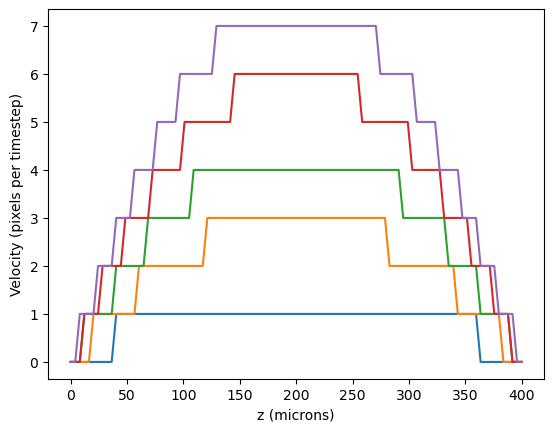

In [12]:
x_values = np.linspace(0,400e-6,100)

plt.plot(x_values*10**6,calc_velocity(x_values,1))
plt.plot(x_values*10**6,calc_velocity(x_values,2))
plt.plot(x_values*10**6,calc_velocity(x_values,3))
plt.plot(x_values*10**6,calc_velocity(x_values,4))
plt.plot(x_values*10**6,calc_velocity(x_values,5))
plt.xlabel("z (microns)")
plt.ylabel("Velocity (pixels per timestep)")
plt.show()

In [14]:
# use the velocity profile to create the particle positions
# set some parameters for the measurement and the flow
average_velocity = 2e-3 # m/s
a_scan_rate = 5e3 # hertz
N_A_scans = 512   # number of A scans per B scan
N_B_scans = 10 # number of b scans

# from this calculate the b scan time:
b_scan_time = 1/a_scan_rate*N_A_scans

# otherwise set the b scan time manually
b_scan_time = b_scan_time  # in that case change this

print('B scan time is: ',b_scan_time)

# from flow speed to pixels per b scan
pixels_per_second = round(average_velocity * 1/L)
pixels_per_b_scan = round(pixels_per_second*b_scan_time)

print("The amount of pixels moved after a b scan is: ",pixels_per_b_scan)

# define the location of the flow channel in the sample
z_surface = 0.2e-3
z_min_channel = 0.4e-3
z_max_channel = 0.8e-3

# create an array for all particle positions over all scans
particle_positions = np.zeros([N_A_scans,number_of_particles,N_B_scans])

# number of particles per area:
num_part1 = int(round(number_of_particles/D*(z_min_channel-z_surface)))  # number of particles in area 1 calculated by size
num_part2 = int(round(number_of_particles/D*(z_max_channel-z_min_channel)))+1 # the plus one is due to rounding down errors
num_part3 = int(round(number_of_particles/D*(D+z_surface-z_max_channel)))

# for area 1,2 en 3 allocate the positions randomly
# create arrays for all positions in all a scans
z_particles_1 = np.zeros([N_A_scans,num_part1,N_B_scans])
z_particles_2 = np.zeros([N_A_scans,num_part2,N_B_scans])
z_particles_3 = np.zeros([N_A_scans,num_part3,N_B_scans])

# create the first particle positions of the t=0 instance
for x_index in range(N_A_scans):

    z_particles_1[x_index,:,0] = np.sort(z_surface + np.random.uniform(0,1,num_part1)*(z_min_channel-z_surface))
    
    z_particles_3[x_index,:,0] = np.sort(z_max_channel + np.random.uniform(0,1,num_part3)*(D+z_surface-z_max_channel))

    # create the particles in the channel at t=0
    z_particles_2[x_index,:,0] = np.sort(z_min_channel + np.random.uniform(0,1,num_part2)*(z_max_channel-z_min_channel))
    
    # allocate the particle positions at t=0
    particle_positions[x_index,:,0] = np.sort(np.concatenate((z_particles_1[x_index,:,0],z_particles_2[x_index,:,0],z_particles_3[x_index,:,0])))

# create the effect of flow in over all b scans
for B_scan in range(1,N_B_scans):

    # set the z1 and a3 
    z_particles_1[:,:,B_scan] = z_particles_1[:,:,0]
    z_particles_3[:,:,B_scan] = z_particles_3[:,:,0]


    # calculate the velocity profile
    velocity_profile = calc_velocity(z_particles_2[0,:,0]-400e-6,pixels_per_b_scan)

    max_velocity = int(np.max(velocity_profile))

    # create new random data array 
    part_2_new = np.zeros([max_velocity*B_scan,num_part2])

    for x_drag in range(max_velocity*B_scan):
        part_2_new[x_drag,:] = np.sort(z_min_channel + np.random.uniform(0,1,num_part2)*(z_max_channel-z_min_channel))

    # iterate over the different velocities in the profile
    for velocity in range(max_velocity+1):

        z_index_at_v = velocity_profile==velocity

        # for every b scan shift the speckle in the channel and create new speckle at the start

        # here set the new data in the particles 2 zone
        z_particles_2[:B_scan*velocity,z_index_at_v,B_scan] = part_2_new[:B_scan*velocity,z_index_at_v]

        # now move the old particles
        z_particles_2[B_scan*velocity:,z_index_at_v,B_scan] = np.roll(z_particles_2[:,z_index_at_v,0],velocity*B_scan,axis=0)[B_scan*velocity:,:]



for A_scan in range(N_A_scans):

    particle_positions[A_scan,:,:] = np.concatenate((z_particles_1[A_scan,:,:],z_particles_2[A_scan,:,:],z_particles_3[A_scan,:,:]))



B scan time is:  0.1024
The amount of pixels moved after a b scan is:  8


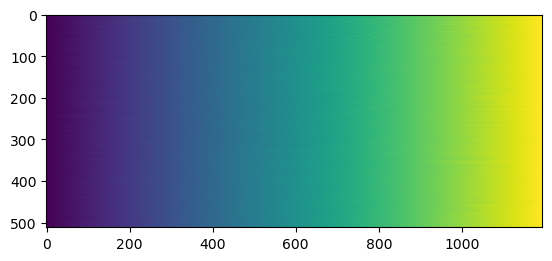

[[0.00055942 0.00056113 0.00056206 ... 0.00063946 0.00063996 0.00064048]
 [0.00054242 0.00054262 0.00054276 ... 0.00062833 0.00062844 0.00062932]
 [0.00054909 0.00054934 0.00054988 ... 0.000626   0.0006273  0.00062806]
 ...
 [0.00054652 0.00054724 0.0005474  ... 0.00062449 0.00062459 0.00062522]
 [0.00054725 0.00054907 0.00054907 ... 0.00062474 0.0006248  0.00062869]
 [0.00055429 0.00055561 0.00055597 ... 0.00062629 0.00062714 0.00062741]]


In [15]:
plt.imshow(particle_positions[:,:,4])
plt.show()
print(z_particles_2[:,velocity_profile==12,0])

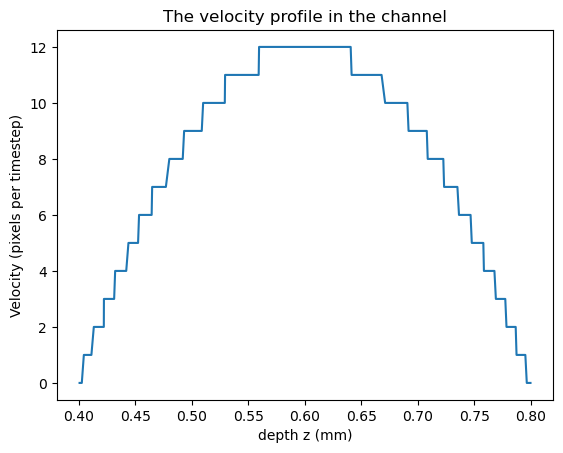

In [18]:
z_range = z_particles_2[0,:,0]

plt.plot(z_range*1000,calc_velocity(z_range-400e-6,8))
plt.xlabel("depth z (mm)")
plt.ylabel("Velocity (pixels per timestep)")
plt.title("The velocity profile in the channel")
#plt.savefig("/Users/bramzijlstra/Desktop/!Simulation_plots/Velo_profile,parabolic.pdf")
plt.show()

In [12]:

def create_speckle_image(particle_positions, N_A_scans):

    # create the image array:
    speckle_image = np.zeros([int(M/2),N_A_scans])

    # calculate the a scans
    for a_scan_num in range(N_A_scans):

        # retrieve the particle positions
        z_part = particle_positions[a_scan_num,:]

        # create an array with the count of all particles
        cnt = np.arange(number_of_particles)

        # calculate the transmission coefficient for each particle
        transm = (1-(Q*np.pi*(particle_diameter/2)**2/L**2))**(cnt)

        # define and create a phase factor for each particle
        phase_factors = np.zeros([num_samples,number_of_particles],dtype=complex)

        for a in np.arange(1,number_of_particles):
            phase_factors[:,a] = np.sqrt(R_part)*transm[a-1]*np.exp(1j*2*z_part[a]*k_space)

        phase_factors = np.sum(phase_factors,1)

        # calculate the fields due to the reference and the sample
        Ek_sample = np.sqrt(alpha*(1-alpha))*np.sqrt(signal_k_space)*phase_factors
        Ek_ref = np.sqrt(alpha*(1-alpha))*np.sqrt(signal_k_space)

        # using the fields calculate the intensity
        Ik_int = (Ek_sample+Ek_ref)*np.conj(Ek_sample+Ek_ref) - Ek_sample*np.conj(Ek_sample)-Ek_ref*np.conj(Ek_ref)

        # calculate the OCT signal
        OCT_signal = np.fft.ifftshift(np.fft.ifft(Ik_int))

        # place a scan in the matrix
        speckle_image[:,a_scan_num] = np.abs(OCT_signal[int(M/2):])

    return speckle_image

In [13]:
# create the timeseries data
image_timeseries = np.zeros([int(M/2),N_A_scans, N_B_scans])
for B_scan in range(N_B_scans):
    print(B_scan)
    image_timeseries[:,:,B_scan] = create_speckle_image(particle_positions[:,:,B_scan],N_A_scans)

0
1
2
3
4
5
6
7
8
9


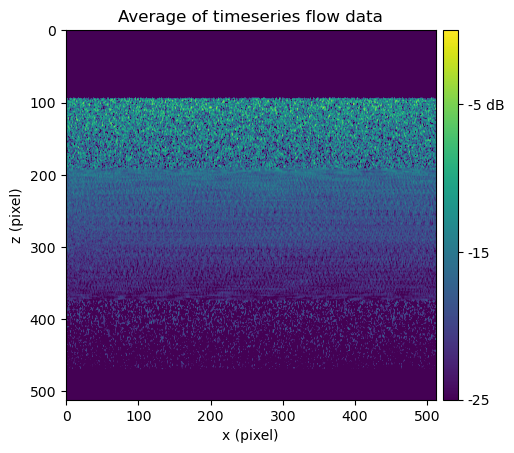

In [23]:
# plot the average over the timeseries of the data
image_average = np.average(image_timeseries,2)
fig1,ax=DataProcessingOCT.plot_Bscan_image(image_average,dBlevel=25,title='Average of timeseries flow data')
#plt.savefig("/Users/bramzijlstra/Desktop/Intensity,average,profile.pdf")
plt.show()

In [18]:
#np.save("timeseries_512-512-10-velocity-profile.npy",image_timeseries)

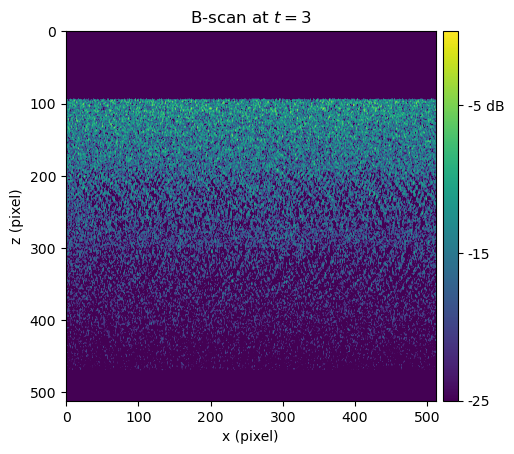

In [24]:
image_average = np.average(image_timeseries,2)
fig1,ax=DataProcessingOCT.plot_Bscan_image(image_timeseries[:,:,4],dBlevel=25,title='B-scan at $t=3$')
#plt.savefig('/Users/bramzijlstra/Desktop/Flow_profile,weird_distortion.pdf')
plt.show()